# November 29th, 2021 (figs 1 and 2)

**Motivation**: Using proportional thresholding at 10% density and K = 4 and 5 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [23]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi, approach='pi_animals'):
    if approach == 'pi_animals':
        # pi = bn.nanmean(pi, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        # h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    else:
        msg = 'invalid mode, available options:\n'
        msg += "{'pi_animals', 'avg_pi_first', 'no_pi_avg'}"
        raise RuntimeError(msg)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p10-sample', **props_base}

## Group results

In this section I combine memberships from all runs to get group averaged membership vectors.

In [5]:
# HIDE CODE


# Group results
gr = Group(mode='ca2', centroids_from='all', **props_ca)
group_ca = gr.fit_group(skip_align=False)

gr = Group(mode='bold-lite', centroids_from='all', **props_bold)
group_bold = gr.fit_group(skip_align=False)

# Make & apply statistic
bins = np.linspace(0.2, 1.0, 5)
statistic = mk_statistic_fn(bins, False)

output_ca = statistic(group_ca['gam_run'])
output_bold = statistic(group_bold['gam_run'])

# Proj
_disj = gr.get_disjoint_community(output_ca['pi_avg'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_avg'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_avg'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_avg'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

### Memberships visualized on cortex

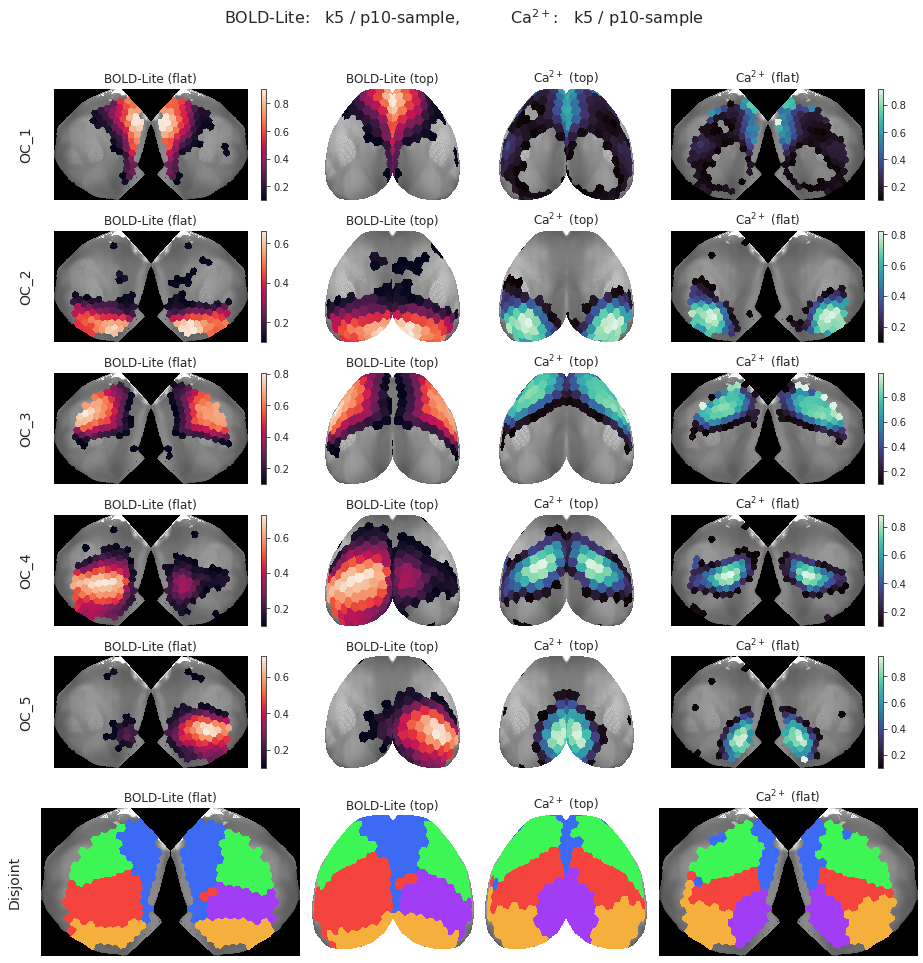

In [6]:
# HIDE CODE


# Make fig

fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

### Region entropies plot

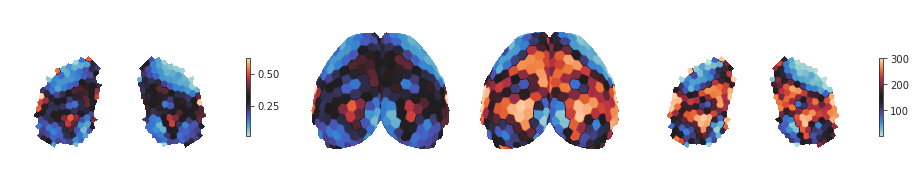

In [28]:
_pi = pi_from_gam(group_ca['gam_run'])
h, hr, proj_h, proj_hr = get_h(_pi, approach='no_pi_avg')
_ = show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

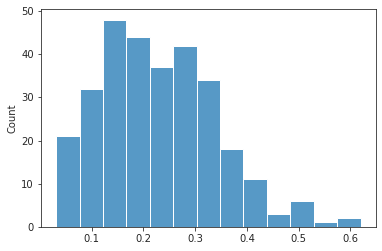

In [29]:
sns.histplot(h)

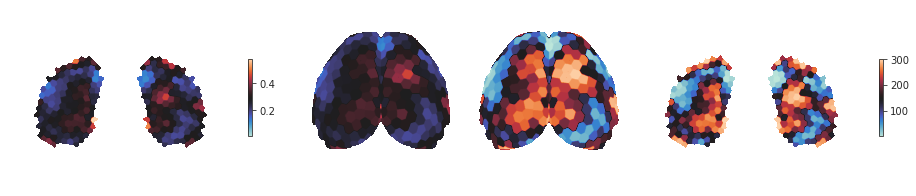

In [30]:
_pi = pi_from_gam(group_bold['gam_run'])
h, hr, proj_h, proj_hr = get_h(_pi, approach='no_pi_avg')
_ = show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

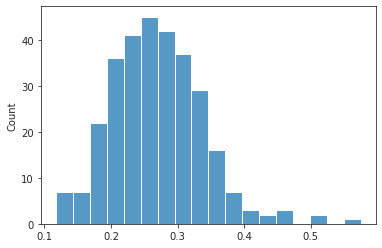

In [31]:
sns.histplot(h)

### Bootstrap + group figures

In [35]:
# HIDE CODE


# Do boot
# boot_bca, boot_gam = do_boot(
#    gam_ca=group_ca['gam_run'],
#     gam_bold=group_bold['gam_run'],
#     save_dir=tmp_dir,
#     n_resamples=1000,
#     bins=bins,
# )

# Load SciPy boot
boot_bca = 'boot-BCa_1000_(2021_11_28).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = 'boot-gam_1000_(2021_11_28).npy'
boot_gam = np.load(pjoin(tmp_dir, boot_gam), allow_pickle=True)
boot_gam = boot_gam.item()

# Prepare gam booted
_stat = mk_statistic_fn(bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca'])
output_booted_bold = _stat(boot_gam['bold'])
output_booted_ca['cut'].shape, output_booted_bold['cut'].shape

((1000, 10, 5, 4), (1000, 10, 5, 4))

In [36]:
# HIDE CODE


# Make dfs for group plot

dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_ca['cut']),
            'oc_idx': [i + 1] * len(output_ca['cut']),
            'color': [gr.colors[i + 1]] * len(output_ca['cut']),
            'subject': range(len(output_ca['cut'])),
            'mean': output_ca['cut'][:, i, j],
            'se': [boot_bca['ca2']['se'][i, j]] * len(output_ca['cut']),
        })
df_ca = pd.DataFrame(merge_dicts(dlist))


dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_bold['cut']),
            'oc_idx': [i + 1] * len(output_bold['cut']),
            'color': [gr.colors[i + 1]] * len(output_bold['cut']),
            'subject': range(len(output_bold['cut'])),
            'mean': output_bold['cut'][:, i, j],
            'se': [boot_bca['bold']['se'][i, j]] * len(output_bold['cut']),
        })
df_bold = pd.DataFrame(merge_dicts(dlist))

#### Fig 1 for Ca2

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_Ca2_(2021_11_29).pdf

done.

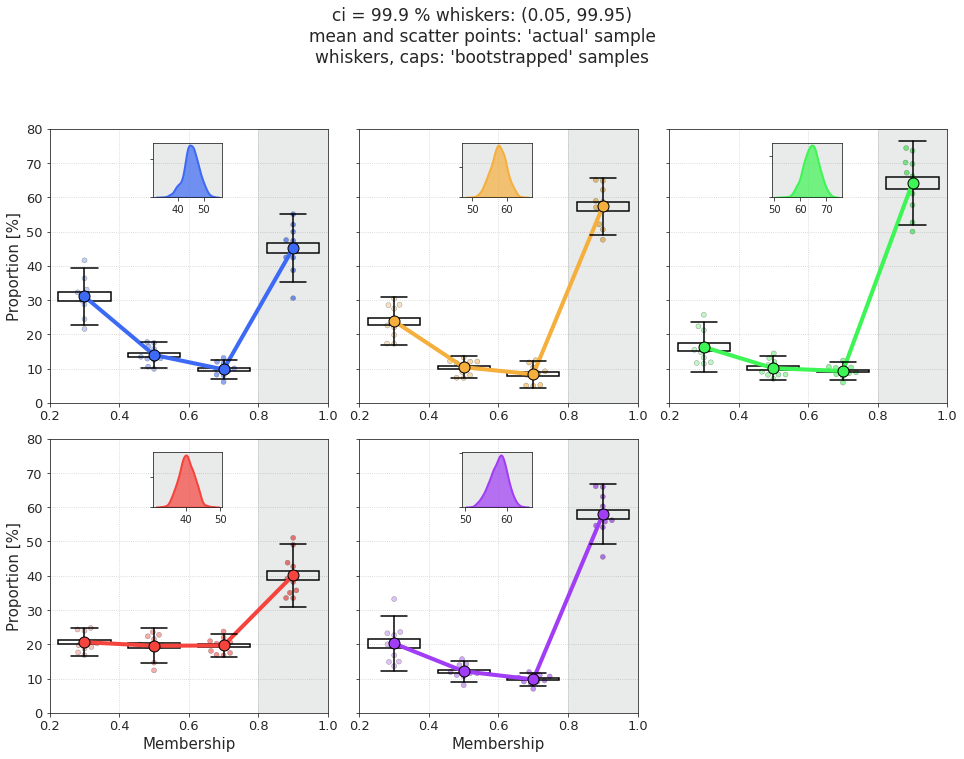

In [37]:
# HIDE CODE


# group fig, Ca2
figs, sups, axes, axes_inset = plot_group(
    df_real=df_ca,
    inset_kind='kde',
    inset_data=output_booted_ca['cut_avg'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_Ca2_{now()}.pdf"),
)
figs[-1]

#### Fig 1 for BOLD

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_BOLD_(2021_11_29).pdf

done.

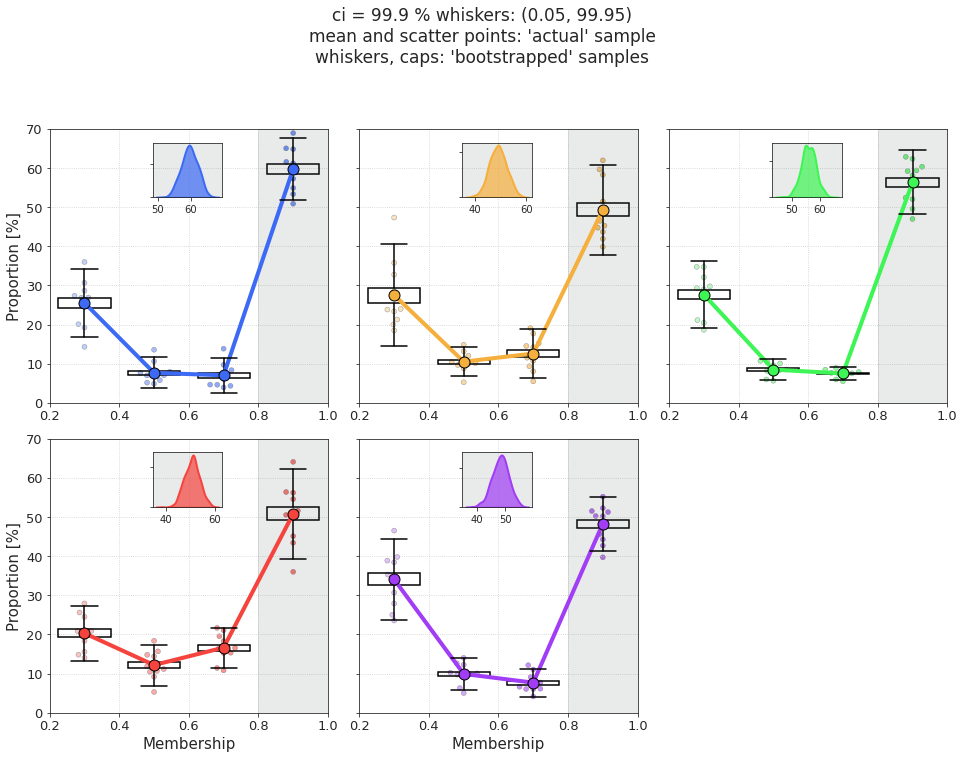

In [38]:
# HIDE CODE


# group fig, BOLD
figs, sups, axes, axes_inset = plot_group(
    df_real=df_bold,
    inset_kind='kde',
    inset_data=output_booted_bold['cut_avg'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_BOLD_{now()}.pdf"),
)
figs[-1]

#### Last bin proportions side by side

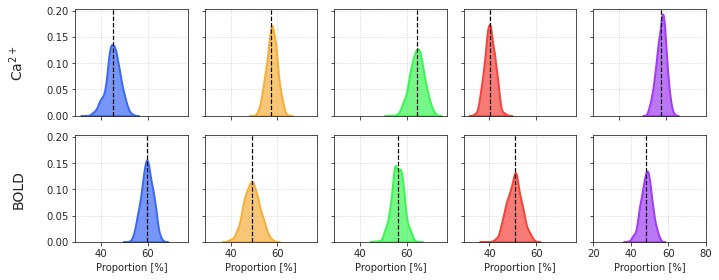

In [39]:
# HIDE CODE


fig, axes = create_figure(2, props_base['num_k'], (10, 4.), 'all', 'all')
for i in range(props_base['num_k']):
    data = output_booted_ca['cut_avg'][:, i, -1]
    mean_real = output_ca['cut_avg'][i, -1]
    axes[0, i].axvline(mean_real, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data,
        color=gr.colors[i+1],
        shade=True,
        alpha=0.7,
        lw=2.,
        ax=axes[0, i],
    )
    
    data = output_booted_bold['cut_avg'][:, i, -1]
    mean_real = output_bold['cut_avg'][i, -1]
    axes[1, i].axvline(mean_real, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data,
        color=gr.colors[i+1],
        shade=True,
        alpha=0.7,
        lw=2.,
        ax=axes[1, i],
    )
    
    xticks = axes[1, i].get_xticks()
    axes[1, i].set_xticks([e for e in xticks if int(e) == np.round(e, 1)])
    axes[1, i].set_xlabel('Proportion [%]')
    # axes[1, i].tick_params(axis='y', labelleft=False)
    # axes[1, i].set_ylabel('')
    axes[1, i].grid()
    axes[0, i].grid()
    if i == 0:
        axes[0, i].set_ylabel(r'Ca$^{2+}$'+'\n', fontsize=14)
        axes[1, i].set_ylabel('BOLD\n', fontsize=14)
# trim_axs(axes, gr.num_k)
plt.show()

### Permutation test (compare last bin)

In [267]:
x = [output_ca['cut'][..., -1], output_bold['cut'][..., -1]]
x = np.concatenate(x)
x.shape

(20, 5)

In [268]:
a_true = x[:10].mean(0)
b_true = x[10:].mean(0)
delta_true = a_true - b_true
delta_true

array([-14.53147036,   8.03652849,   7.95871621, -10.66110811,
         9.61178937])

In [269]:
rng = get_rng()
n_iter = int(1e6)
delta = []
for i in tqdm(range(n_iter)):
    ids = rng.permutation(len(x))
    permuted = x[ids]
    a = permuted[:len(x)//2].mean(0, keepdims=True)
    b = permuted[len(x)//2:].mean(0, keepdims=True)
    delta.append(a - b)
delta = np.concatenate(delta)
delta.shape

  0%|          | 0/1000000 [00:00<?, ?it/s]

(1000000, 5)

In [270]:
pval = (np.abs(delta) > np.abs(delta_true).reshape(1, 5)).mean(0)
pval

array([6.5000e-05, 2.1481e-02, 2.5908e-02, 4.5530e-03, 1.5710e-03])

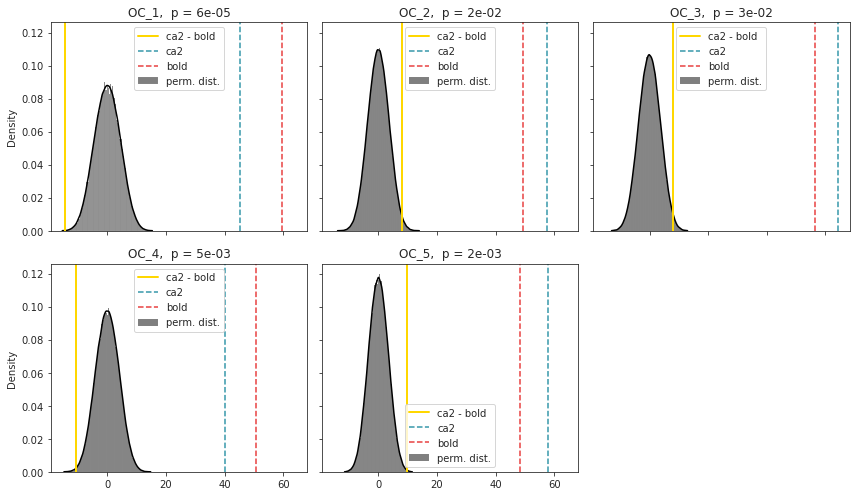

In [271]:
fig, axes = create_figure(2, 3, (12, 7), 'all', 'all')
for i, ax in enumerate(axes.flat):
    if i == 5:
        continue
    sns.histplot(
        data=delta[:, i],
        color='k',
        stat='density',
        label='perm. dist.',
        kde=True,
        ax=ax,
    )
    ax.axvline(delta_true[i], color='gold', label='ca2 - bold', lw=2.)
    ax.axvline(a_true[i], ls='--', color=pal['ca2'], label='ca2')
    ax.axvline(b_true[i], ls='--', color=pal['bold'], label='bold')
    ax.set_title(f"OC_{i+1},  p = {pval[i]:1.0e}")
    ax.legend()
trim_axs(axes, 5)
plt.show()

## Maximum membership values

In [128]:
mice = Mice((192, 4))
mice.setup_func_data('rest')

In [96]:
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold': rocket(0.6)}

In [237]:
# HIDE CODE

theta_all = collections.defaultdict(dict)
dlist1, dlist2 = [], []
for k in [4, 5]:
    props_base = {
        'num_k': k,
        'mice': mice,
        'task': 'rest',
        'metric': 'pearson',
        'match_using': 'gam',
        'match_metric': 'euclidean',
        'prepare_data': False,
        'verbose': False,
    }
    props_ca = {'perc': 'p10-sample', **props_base}
    props_bold = {'perc': 'p10-sample', **props_base}
    
    # Group results
    gr = Group(mode='ca2', centroids_from='all', **props_ca)
    group_ca = gr.fit_group(skip_align=False)
    gr = Group(mode='bold-lite', centroids_from='all', **props_bold)
    group_bold = gr.fit_group(skip_align=False)
    
    theta_ca, maxmem_ca = compute_theta(group_ca['gam_run'])
    theta_bold, maxmem_bold = compute_theta(group_bold['gam_run'])
    
    maxmem = {
        'ca2': maxmem_ca.ravel(),
        'bold': maxmem_bold.ravel(),
    }
    for mode, x in maxmem.items():
        dlist1.append({
            'maxmem': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
        })

    theta = {
        'ca2': bn.nanmean(bn.nanmean(theta_ca, -1), -1),
        'bold': bn.nanmean(bn.nanmean(theta_bold, -1), -1),
    }
    for mode, x in theta.items():
        dlist2.append({
            'theta': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
            'animal': range(1, len(x) + 1),
        })
    theta_all[k] = theta
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

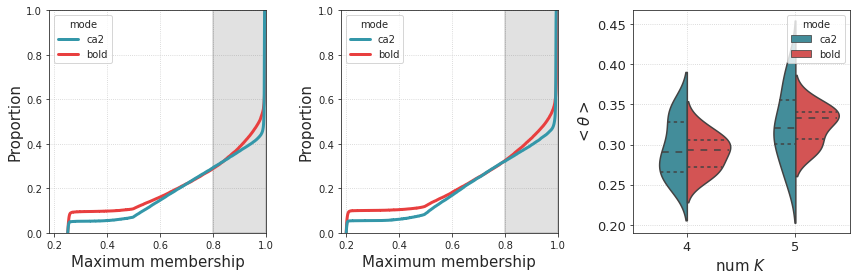

In [238]:
# HIDE CODE


fig, axes = create_figure(1, 3, (12, 4))

for ax, k in zip(axes[:2], [4, 5]):
    ax.axvspan(
        xmin=0.8,
        xmax=1.0,
        lw=2,
        alpha=0.2,
        color='dimgrey',
        label='Disjoint zone',
    )
    sns.ecdfplot(
        data=df1.loc[df1['K'] == k],
        x='maxmem',
        hue='mode',
        palette=pal,
        lw=3,
        ax=ax,
    )
    ax.set_ylabel(r'Proportion', fontsize=15)
    ax.set_xlabel(r'Maximum membership', fontsize=15)
    ax.set_xlim(0.18, 1.0)
    ax.grid()

ax = axes[-1]
sns.violinplot(
    data=df2,
    x='K',
    y='theta',
    hue='mode',
    inner="quartile",
    palette=pal,
    split=True,
    ax=ax,
)
ax.set_ylabel(r'$<\theta>$', fontsize=15)
ax.set_xlabel(r'num $K$', fontsize=15)
ax.tick_params('both', labelsize=13)
ax.grid()

plt.show()

<AxesSubplot:xlabel='K', ylabel='theta'>

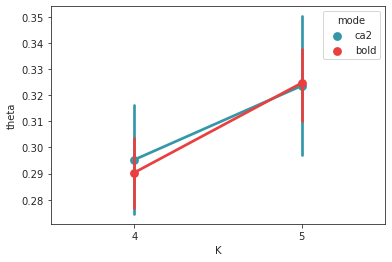

In [239]:
sns.pointplot(
    data=df2,
    x='K',
    y='theta',
    hue='mode',
    palette=pal,
)

In [255]:
x = []
for v in theta_all.values():
    x.append(np.concatenate([v['ca2'], v['bold']]).reshape(1, -1))
x = np.concatenate(x).T
x.shape

(20, 2)

In [256]:
a_true = x[:10].mean(0)
b_true = x[10:].mean(0)
delta_true = a_true - b_true
delta_true

array([ 0.0049311 , -0.00108038])

In [262]:
rng = get_rng()
n_iter = int(1e6)
delta = []
for i in tqdm(range(n_iter)):
    ids = rng.permutation(len(x))
    permuted = x[ids]
    a = permuted[:len(x)//2].mean(0, keepdims=True)
    b = permuted[len(x)//2:].mean(0, keepdims=True)
    delta.append(a - b)
delta = np.concatenate(delta)
delta.shape

  0%|          | 0/1000000 [00:00<?, ?it/s]

(1000000, 2)

In [263]:
pval = (np.abs(delta) > np.abs(delta_true).reshape(1, -1)).mean(0)
pval

array([0.710118, 0.945965])

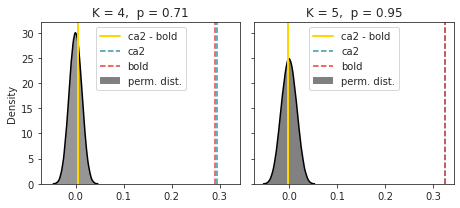

In [266]:
fig, axes = create_figure(1, 2, (6.5, 3.), 'all', 'all')
for i, (ax, k) in enumerate(zip(axes.flat, [4, 5])):
    if i == 5:
        continue
    sns.histplot(
        data=delta[:, i],
        color='k',
        stat='density',
        label='perm. dist.',
        kde=True,
        ax=ax,
    )
    ax.axvline(delta_true[i], color='gold', label='ca2 - bold', lw=2.)
    ax.axvline(a_true[i], ls='--', color=pal['ca2'], label='ca2')
    ax.axvline(b_true[i], ls='--', color=pal['bold'], label='bold')
    ax.set_title(f"K = {k},  p = {pval[i]:.2f}")
    ax.legend(loc='upper center')
plt.show()

## GSR on Ca2 data

In [40]:
mice = Mice((768, 4))
mice.setup_func_data('rest')

In [85]:
key = 'sub-SLC02_ses-3_run-5'
net = Network(mice, key, 'ca2').load_network()

<AxesSubplot:ylabel='Count'>

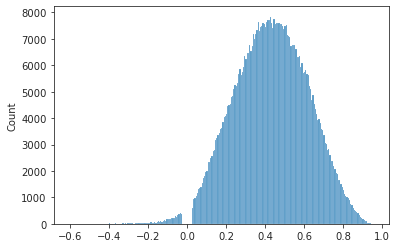

In [86]:
sns.histplot(net.adj[net.adj.nonzero()])

In [87]:
(np.abs(net.adj).mean(0) > 0).sum()

790

In [88]:
net.data.shape

(996, 5500)

In [89]:
nonan = np.where(np.isnan(net.data).sum(1) == 0)[0]
x = net.data[nonan]
x.shape

(790, 5500)

In [91]:
gs = x.mean(0, keepdims=True)
x_gsr = x - gs

[<matplotlib.lines.Line2D object at 0x7fd7b008d0d0>]

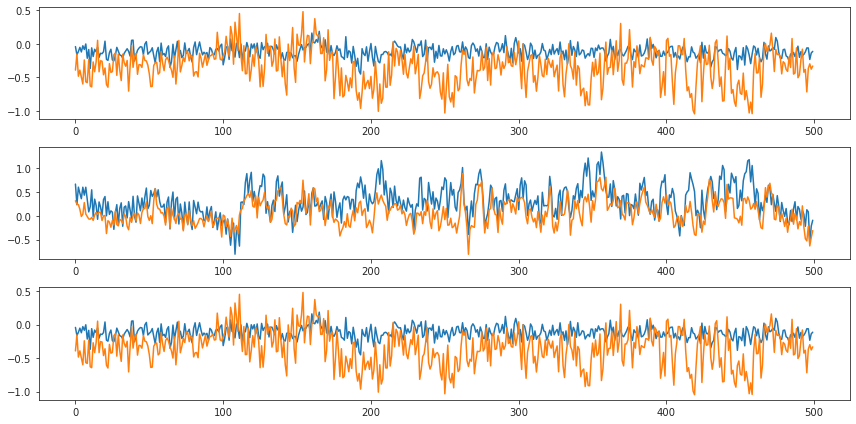

In [92]:
fig, axes = create_figure(3, 1, (12, 6))
axes[0].plot(x[0, :500])
axes[0].plot(x[100, :500])
axes[1].plot(x_gsr[0, :500])
axes[1].plot(x_gsr[100, :500])
axes[2].plot(x_gsr[0, :500] + gs[0, :500])
axes[2].plot(x_gsr[100, :500] + gs[0, :500])

[<matplotlib.lines.Line2D object at 0x7fd753306400>]

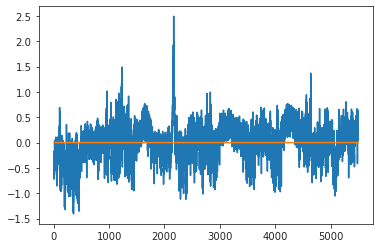

In [93]:
plt.plot(gs.T)
plt.plot(x_gsr.mean(0))

In [94]:
a, _ = get_adj_mat(x, 'pearson')
a_gsr, _ = get_adj_mat(x_gsr, 'pearson')

<AxesSubplot:ylabel='Density'>

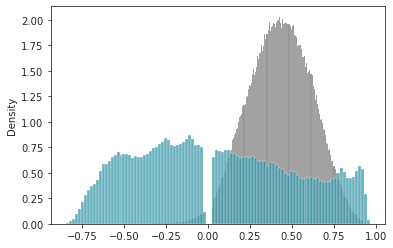

In [97]:
sns.histplot(a[a.nonzero()], stat='density', color='dimgrey')
sns.histplot(a_gsr[a_gsr.nonzero()], stat='density', color=pal['ca2'])

[<matplotlib.lines.Line2D object at 0x7fd7a0ff6670>]

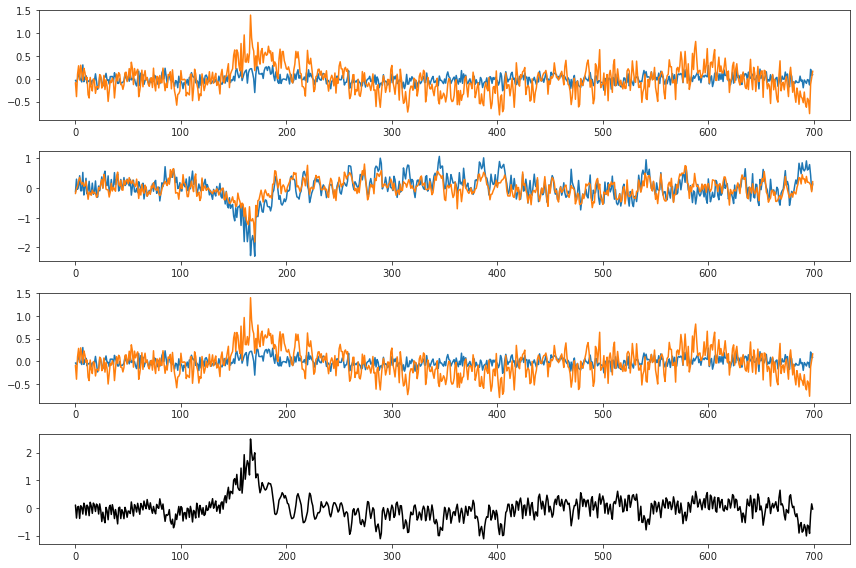

In [103]:
intvl = range(2000, 2700)

fig, axes = create_figure(4, 1, (12, 8))
axes[0].plot(x[0, intvl])
axes[0].plot(x[100, intvl])
axes[1].plot(x_gsr[0, intvl])
axes[1].plot(x_gsr[100, intvl])
axes[2].plot(x_gsr[0, intvl] + gs[0, intvl])
axes[2].plot(x_gsr[100, intvl] + gs[0, intvl])
axes[3].plot(gs[0, intvl], color='k')

In [29]:
n_mixed = (x_ca[0, 0, 0] < 0.8).sum()
n_disjoint = (x_ca[0, 0, 0] >= 0.8).sum()

n_mixed / (n_mixed + n_disjoint)

0.3303964757709251

In [31]:
n_mixed = np.nansum(x_ca < 0.8, -1)
n_disjoint = np.nansum(x_ca >= 0.8, -1)

In [34]:
theta_ca = n_mixed / (n_mixed + n_disjoint)

In [35]:
theta_ca[0,0,0]

0.3303964757709251

In [49]:
theta_ca, maxmem_ca = compute_theta(group_ca['gam_run'])
theta_bold, maxmem_bold = compute_theta(group_bold['gam_run'])

In [50]:
theta_ca[0, 0, 0]

0.3303964757709251

<AxesSubplot:ylabel='Percent'>

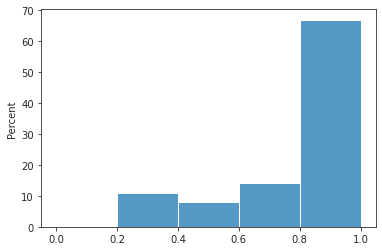

In [53]:
sns.histplot(np.nanmax(pi_ca[0, 0, 0], 0), bins=np.linspace(0, 1.0, 6), stat='percent')

In [63]:
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca': mako(0.6), 'bold': rocket(0.6)}

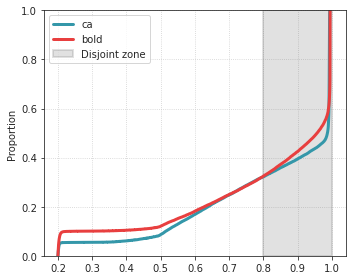

In [76]:
fig, ax = create_figure(1, 1, (5, 4))

sns.ecdfplot(
    data=maxmem_ca.flat,
    color=mako(0.6),
    label='ca',
    lw=3,
    ax=ax,
)
sns.ecdfplot(
    data=maxmem_bold.flat,
    color=rocket(0.6),
    label='bold',
    lw=3,
    ax=ax,
)
ax.axvspan(
    xmin=0.8,
    xmax=1.0,
    lw=2,
    alpha=0.2,
    color='dimgrey',
    label='Disjoint zone',
)
ax.legend()
ax.grid()
plt.show()

In [77]:
theta_avg_ca = bn.nanmean(bn.nanmean(theta_ca, -1), -1)
theta_avg_bold = bn.nanmean(bn.nanmean(theta_bold, -1), -1)

In [80]:
theta_avg_ca

array([0.30593701, 0.29891966, 0.39818258, 0.36592916, 0.37275334,
       0.32318619, 0.25895785, 0.26806699, 0.31810379, 0.32640027])

In [81]:
theta_avg_bold

array([0.33389261, 0.29350104, 0.30406392, 0.34261764, 0.28952389,
       0.33466487, 0.34423126, 0.31586571, 0.33104812, 0.35783158])

In [82]:
theta_avg_ca.mean(), theta_avg_bold.mean()

(0.32364368237752794, 0.32472406537455284)

(0.21600000000000003, 0.2930555555555555)

In [84]:
df = pd.DataFrame({'ca': theta_avg_ca, 'bold': theta_avg_bold})
df = df.melt()
df['K'] = 5

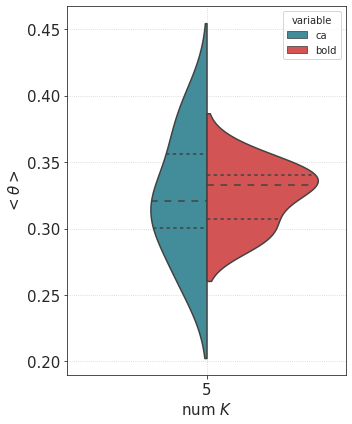

In [102]:
fig, ax = create_figure(1, 1, (5, 6))

sns.violinplot(
    data=df,
    x='K',
    y='value',
    hue='variable',
    inner="quartile",
    palette=pal,
    split=True,
    ax=ax,
)
ax.set_ylabel(r'$<\theta>$', fontsize=15)
ax.set_xlabel(r'num $K$', fontsize=15)
ax.tick_params('both', labelsize=15)
ax.grid()

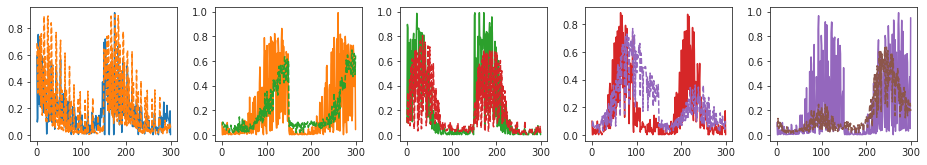

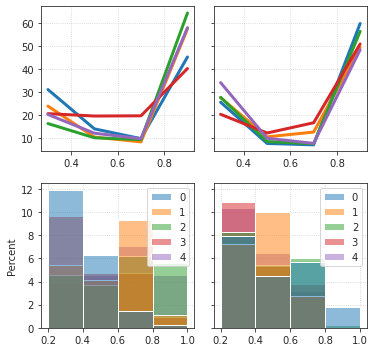

In [89]:
fig, axes = create_figure(1, props_base['num_k'], (13, 2.4))

for i, ax in enumerate(axes.flat):
    try:
        ax.plot(output_ca['pi_avg'][i], color=f'C{i}')
        ax.plot(output_bold['pi_avg'][i], color=f'C{i+1}', ls='--')
    except IndexError:
        continue
plt.show()


fig, axes = create_figure(2, 2, (5.5, 5), sharey='row')

axes[0, 0].plot((bins[:-1] + bins[1:]) / 2, output_ca['cut_avg'].T, lw=3)
axes[0, 1].plot((bins[:-1] + bins[1:]) / 2, output_bold['cut_avg'].T, lw=3)

sns.histplot(output_ca['pi_avg'].T, bins=bins, stat='percent', ax=axes[1, 0])
sns.histplot(output_bold['pi_avg'].T, bins=bins, stat='percent', ax=axes[1, 1])

for ax in axes.flat:
    ax.grid()

plt.show()